## Art Dating

#### Students
- Zhenbang Chen
- Zhenjia Chen

### Setup

Importing packages and dependencies.  Load dataset for categorization.

In [1]:
import os
import copy
from PIL import Image
rootpath = "."

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm.auto import tqdm
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2
Using the GPU!


### Model Initialization

In [3]:
def initialize_model(num_classes, resume_from=None):
    
    if resume_from:
        model_ft = models.resnet50(pretrained=False)
        
        in_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features, num_classes)
        
        model_ft.load_state_dict(torch.load(resume_from))
        
        return model_ft
    else:
        # Model (nn.Module) to return
        # model_ft = models.resnet18(pretrained = false)
        model_ft = models.resnet50(pretrained=False)

        in_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features, num_classes)

        return model_ft

### Tests

In [6]:
# Transform to apply to the data
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
# ])

# Transform to apply to the data for use with pretrained ResNet model
transform = torchvision.transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
# Get training data from directory
art_train = torchvision.datasets.ImageFolder(root="./data/art_culture_train",
                                                 transform=transform)

# Get validation data from directory
art_val = torchvision.datasets.ImageFolder(root="./data/art_culture_val",
                                               transform=transform)

# Get testing data from directory
art_test = torchvision.datasets.ImageFolder(root="./data/art_culture_test",
                                               transform=transform)

In [8]:
# Create random sampler
random_sampler = torch.utils.data.RandomSampler(data_source=art_train,
                                                replacement=True,
                                                num_samples=int(len(art_train)/10))

# Create batched dataloader
art_train_loader = torch.utils.data.DataLoader(dataset=art_train,
                                                   batch_size=8,
                                                   shuffle=True,
                                                   num_workers=4,
                                                   pin_memory=True)

# art_train_loader = torch.utils.data.DataLoader(dataset=art_train,
#                                                    batch_size=8,
#                                                    sampler=random_sampler,
#                                                    shuffle=False,
#                                                    num_workers=4,
#                                                    pin_memory=True)

art_val_loader = torch.utils.data.DataLoader(dataset=art_val,
                                                 batch_size=8,
                                                 shuffle=False,
                                                 num_workers=4,
                                                 pin_memory=True)

art_test_loader = torch.utils.data.DataLoader(dataset=art_test,
                                                 batch_size=8,
                                                 shuffle=False,
                                                 num_workers=4,
                                                 pin_memory=True)

### Initialization and Methods

In [7]:
# Initialize model
# model = torchvision.models.resnet18(pretrained=False)
# model = torchvision.models.resnet50(pretrained=True)

# Set number of output classes
# model.conv1 = nn.Conv2d(in_channels=3,
#                         out_channels=64,
#                         kernel_size=(7,7),
#                         stride=(2,2),
#                         padding=(3,3),
#                         bias=False)

# in_features = model.fc.in_features
# out_features = 11
# model.fc = nn.Linear(in_features, out_features)

# model = model.to(device)

model = initialize_model(num_classes=11).to(device)

In [9]:
# Training method
def train(net, optim, criterion,train_loader):
    net.train()
    for image_cpu, label_cpu in tqdm(train_loader):
        # Move image and label to GPU
        image = image_cpu.to(device)
        label = label_cpu.to(device)
        
        # Clear gradient
        optim.zero_grad()
        
        # Forward through the network
        output = net(image)
        
        # Loss and gradient
        loss = criterion(output, label)
        loss.backward()
        
        # Update paramters
        optim.step()

In [10]:
# Evaluation method
def evaluate(net, val_loader, top_n=1):
    total = 0
    correct = 0
    net.eval()
    
    for image_cpu, label_cpu in tqdm(val_loader):
        # Move image and label to GPU
        image = image_cpu.to(device)
        label = label_cpu.to(device)
        tiled_labels = torch.stack([label for _ in range(top_n)], dim=1) 

        
        # Don't track gradients for performance in evaluation
        with torch.no_grad():
            # Get prediction with forward pass
#             prediction = net(image).argmax(dim=-1)
            
            # Get the indices of the top_n predictions
            prediction = net(image).topk(k=top_n, dim=-1)[1]
            
            # Total number in batch
            total += image.size(0)
            
            # Number correct in batch
#             correct += (prediction == label).sum().item()
            # Number correct in batch
            correct += (prediction == tiled_labels).sum().item()
            
    return correct/total

In [11]:
# Validation method
def validate(net, optim, criterion, val_loader):
    total = 0
    running_loss = 0
    correct = 0
    net.eval()
    
    for image_cpu, label_cpu in tqdm(val_loader):
        # Move image and label to GPU
        image = image_cpu.to(device)
        label = label_cpu.to(device)
        
        # Clear gradient
        optim.zero_grad()
        
        # Don't track gradients for performance in validation
        with torch.no_grad():
            # Forward through the network
            output = net(image)
            
            # Get prediction with forward pass
            prediction = output.argmax(dim=-1)

            # Loss and gradient
            loss = criterion(output, label)
            
            # Total number in batch
            total += image.size(0)
            
            # Accumulate loss
            running_loss += loss.item()
            
            # Number correct in batch
            correct += (prediction == label).sum().item()
            
    return running_loss/total, correct/total

### Training

In [12]:
# Create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Create criterion
criterion = torch.nn.CrossEntropyLoss()

# Create scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=4, gamma=0.1)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
#                                                  mode="min",
#                                                  factor=0.2,
#                                                  patience=1,
#                                                  verbose=True,
#                                                  threshold=0.01)

NameError: name 'model' is not defined

In [ ]:
# Start training
num_epochs = 15

print("start")

best_state_dict = {}
best_val_acc = 0
for epoch in range(num_epochs):
    print("Epoch {}".format(epoch))
#     val_acc = evaluate(model, art_val_loader) * 100
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_state_dict = copy.deepcopy(model.state_dict())
    
    train(model, optimizer, criterion, art_train_loader)
    val_loss, val_acc = validate(model, optimizer, criterion, art_val_loader)
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = copy.deepcopy(model.state_dict())
    
    print("Val Loss - Epoch {}: {}".format(epoch, val_loss))
    print("Val Acc - Epoch {}: {}%".format(epoch, val_acc))
    
    if epoch % 4 == 0 and epoch != 0:
        torch.save(best_state_dict, "./models/art_culture_temp_epoch" + str(epoch))
    
print("Done! {}%".format(evaluate(model, art_val_loader) * 100))

In [ ]:
# Save model
torch.save(best_state_dict, "./models/art_culture_steplr001_step4_gamma01_epoch15_scratch")

### Testing

In [14]:
# Load the model to test
model = initialize_model(num_classes=11,
                         resume_from="./models/art_culture_platlr0001_fac02_pat1_thres001_epoch30").to(device)

test_acc = evaluate(net=model, val_loader=art_test_loader, top_n=3)
print("Done!", test_acc)


Done! 0.918429003021148


### Visualize Activations

In [13]:
import cv2
from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL.Image

In [15]:
def generate_featuremap_unit(resnet,unit_id,im_input):
    #Extract activation from model
    #TODO: remove the last 2 layers of resnet 
    model_cut = nn.Sequential(*(list(resnet.children())[:-2]))

    # Mark the model as being used for inference
    model_cut.eval()
    # Crop the image
    im = transform(im_input).to(device)
    # Place the image into a batch of size 1, and use the model to get an intermediate representation
    
    with torch.no_grad():
        out = model_cut(im.unsqueeze(0))
        # Print the shape of our representation
        print(out.size())
        # Extract the only result from this batch, and take just the `unit_id`th channel
    #     out_final = out.squeeze()[unit_id]

        out_sums = out.squeeze().sum(dim=(1,2), keepdim=True)
        out_sums = torch.where(out_sums != 0, out_sums, torch.ones(out_sums.size()).to(device))
        out_final = (out.squeeze() / out_sums).sum(dim=0)

    #     out_final = out.squeeze().sum(dim=0)

    #     print(out_final.size())
        print(out_final)

        # Return this channel
        return out_final

In [16]:
def visualize_featuremap(im_input,feature_map,alpha=0):
    # Normalize to [0..1], with a little leeway (0.9999) in case feature_map has 0 range
    feature_map = feature_map/(feature_map.max()+1e-10)
    # Convert to numpy (detach() just seperates a tensor from the gradient)
    feat_numpy = feature_map.detach().cpu().numpy()
    # Resize the feature map to our original image size (our strided conv layers reduce the size of the image)
    feat_numpy = cv2.resize(feat_numpy,(im_input.shape[1],im_input.shape[0]))
    # Invert to make the heatmap look more natural
    map_t = 1-feat_numpy
    # Add an extra dimension to make this a [H,W,C=1] image 
    feat_numpy = np.expand_dims(feat_numpy, axis=2)
    
    # Convert to image (UINT8 from 0-255)
    map_t = 255*map_t
    map_t = map_t.astype(np.uint8)
    # Use a color map to change this from BW to a nice color
    map_t = cv2.applyColorMap(map_t, cv2.COLORMAP_JET)
    # Combine the heatmap with the original image so you can see which section of the image is activated
    im_final = np.multiply((alpha*im_input + (1-alpha)*map_t), feat_numpy) + np.multiply(im_input, 1-feat_numpy)
    # Return final visualization
    return im_final

In [17]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

torch.Size([1, 2048, 7, 7])
tensor([[50.0597, 19.2727, 36.5087, 42.5292, 37.6471, 26.1663, 22.2702],
        [16.4958, 25.0632, 42.4655, 57.8073, 53.3108, 45.9328, 42.7372],
        [15.2229, 30.2185, 46.0137, 60.3818, 55.1807, 48.2993, 44.3196],
        [19.9733, 45.5491, 50.4503, 61.8876, 58.7441, 58.6636, 47.0298],
        [19.8167, 34.1609, 39.2150, 52.0384, 56.5391, 58.4091, 53.8362],
        [12.9811, 20.2066, 31.7792, 44.2902, 45.1308, 54.4515, 56.6941],
        [15.9506, 22.0961, 41.8333, 57.2110, 44.0272, 61.1061, 65.0258]],
       device='cuda:0')


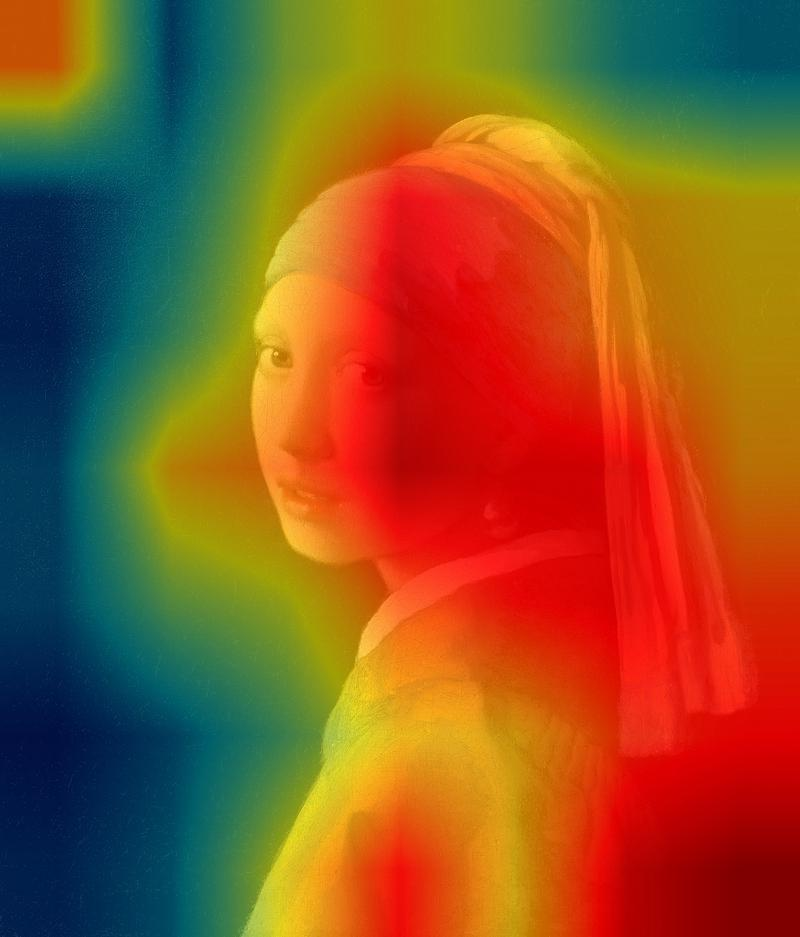

In [21]:
# img0 = load_image("test_images/american_gothic.jpg").to(device)

culture = "american"
image_index = "442"

img0 = PIL.Image.open("test_images/pearl.jpg").convert("RGB")
# img0 = PIL.Image.open("./data/art_culture_all_filtered/" + culture + "/" + str(image_index) + ".jpg").convert("RGB")
img_numpy = np.array(img0)

feat = generate_featuremap_unit(model,0,img0)
im_final = visualize_featuremap(img_numpy,feat)
showarray(im_final)

### Compute Separation

In [18]:
def compute_culture_center(culture, model):
    '''Calculates the average Euclidean center of the all image outputs for a culture using model'''
    
    # Get list of all image files in the appropriate folder
    image_files = os.listdir("data/art_culture_all_filtered/" + culture)[:]
    
    # Switch to evaulation mode
    model.eval()
    
    # Variable for accumulating outputs
    total_tensor = torch.zeros((1,11)).to(device)
    total_images = len(image_files)
    
    # Iteratively accumulate outputs in total_tensor
    for file in image_files:
        image = load_image("data/art_culture_all_filtered/" + culture + "/" + file).to(device)
        
        with torch.no_grad():
            result_vec = model(image)
            total_tensor += result_vec
            
    return total_tensor / total_images

# print(compute_culture_center("spanish", model))

In [22]:
# Average Euclidean center of all image outputs for each culture using best model
culture_tensors = {
    "american" : torch.tensor([[ 7.0664,  1.6778, -1.8836, -0.8605, -1.1828,  0.9407, -0.0519, -1.8947, -1.8577, -0.9771, -0.6822]]),
    "british" : torch.tensor([[ 1.3715e+00,  3.6504e+00, -2.1580e+00, -2.0042e-03,  3.3697e-01, 2.0065e+00,  9.8763e-01, -2.6181e+00, -1.0272e+00, -2.6346e+00, -2.5038e-01]]),
    "chinese" : torch.tensor([[-0.6801, -1.5646,  7.2309, -1.5411, -1.5731, -0.1273, -1.0995,  0.2166, -1.4205,  2.1701, -0.9345]]),
    "dutch" : torch.tensor([[-0.7726,  0.0573, -2.4268,  3.7708,  0.8802,  1.4279,  1.2017, -3.0107, 1.2312, -3.2050,  0.4194]]),
    "flemish" : torch.tensor([[-0.5941,  0.9288, -2.2716,  1.5399,  1.8579,  1.8715,  0.8328, -2.9006, 1.2896, -2.9780,  0.3761]]),
    "french" : torch.tensor([[ 0.2759,  0.8285, -2.0896,  0.7542,  0.6249,  3.9568,  0.4689, -3.0201, 0.2730, -2.1955, -0.0474]]),
    "german" : torch.tensor([[-0.1850,  0.7377, -2.0441,  1.2382,  0.3095,  1.1902,  1.7258, -2.0748, 1.1933, -2.6024,  0.3569]]),
    "indian" : torch.tensor([[-0.6212, -2.5173,  1.3177, -2.3141, -2.8249, -1.3583, -0.5100,  7.6875, -0.5083,  0.6289,  0.6106]]),
    "italian" : torch.tensor([[-1.8449, -1.1914, -2.2632,  0.9813,  0.5290,  0.8880,  1.4288, -1.7552, 5.1137, -2.9153,  0.9664]]),
    "japanese" : torch.tensor([[ 0.1553, -2.1064,  2.4003, -2.0872, -2.0149, -0.1749, -1.4981,  0.2818, -1.4746,  8.0753, -0.9232]]),
    "spanish" : torch.tensor([[-0.6073, -0.2381, -1.3960,  0.5750,  0.0869,  1.0328,  0.6943, -0.9015, 0.9975, -2.0954,  1.6449]])
}

In [23]:
def compute_distance_between_cultures(culture1, culture2):
    '''Computes the Euclidean distance between two culture centers'''
    return torch.dist(culture_tensors[culture1], culture_tensors[culture2]).item()

def compute_all_distances_from_culture(culture1):
    '''Computes the Eucliean distance of all cultures from the specified culture'''
    results = []
    for culture2 in culture_categories_list:
        results.append((culture2, compute_distance_between_cultures(culture1, culture2)))
    
    return [x[1] for x in results]
    
#     return sorted(results, key=lambda x: x[1])

# for pair in compute_all_distances_from_culture("american"):
#     print(pair)

In [61]:
culture_distances = []
for culture in culture_categories_list:
    culture_distances.append(compute_all_distances_from_culture(culture))
    
for row in range(len(culture_distances)):
    # Apply function to each value
    for col in range(len(culture_distances[row])):
        if not (abs(culture_distances[row][col]) <= 0.00000001):
            culture_distances[row][col] = 1/culture_distances[row][col]**4
            
#     Normalize each row/culture
#     row_sum = sum(culture_distances[row])
#     for col in range(len(culture_distances[row])):
#         if not (abs(culture_distances[row][col]) <= 0.00000001):
#             culture_distances[row][col] = culture_distances[row][col]/row_sum
    
# print(culture_distances)

print("labels" + " " + " ".join(culture_categories_list))
for row in range(len(culture_distances)):
#     print(culture_distances[row])
    print(culture_categories_list[row] + " " + " ".join([str(x*100000) for x in culture_distances[row]]))

labels american british chinese dutch flemish french german indian italian japanese spanish
american 0.0 47.655111383402364 3.417200735293663 8.44022810512608 11.791001697664866 20.518437406975167 17.12831122914303 2.6260474889213463 4.362641798641833 3.3467925157456846 14.573145047137194
british 47.655111383402364 0.0 3.6190912742706285 67.40195175949951 207.09595402251944 391.516614169216 269.43411503617006 2.4784840290554073 17.19366238060107 2.5005274134541216 97.80734101954609
chinese 3.417200735293663 3.6190912742706285 0.0 2.8895400152171558 3.4279729089246 4.112223793958292 4.499162094406192 9.742377677463718 2.89371468122278 27.908437644329627 6.952552978097605
dutch 8.44022810512608 67.40195175949951 2.8895400152171558 0.0 1956.0422238325468 248.49629400434534 1163.6986336084133 2.1768359147505065 127.39823149275902 1.9134367251336075 258.47037356732676
flemish 11.791001697664866 207.09595402251944 3.4279729089246 1956.0422238325468 0.0 1166.7146664140782 4271.506878553058 2.

In [ ]:
colors = ["#ff0000", "#ff8c00", "#eaff00", "#5eff00", "#00ff2f", "#00ffbb", "#00bbff", "#002fff", "#5d00ff", "#ea00ff", "#ff0088"]

### Miscellaneous

In [19]:
culture_categories = {
    0 : "american",
    1 : "british",
    2 : "chinese",
    3 : "dutch",
    4 : "flemish",
    5 : "french",
    6 : "german",
    7 : "indian",
    8 : "italian",
    9 : "japanese",
    10 : "spanish"
}

culture_categories_list = ["american",
                           "british",
                           "chinese",
                           "dutch",
                           "flemish",
                           "french",
                           "german",
                           "indian",
                           "italian",
                           "japanese",
                           "spanish"]

In [20]:
# Test on one specific example

# from torch.autograd import Variable
import matplotlib.pyplot as plt

def load_image(image_name):
    """Loads an image; returns a batched image tensor"""
    image = PIL.Image.open(image_name).convert("RGB")
#     plt.imshow(image)
    
    image = transform(image)
    
#     plt.imshow(image.permute(1,2,0))
    
    image = image.clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image


def classify_image(model, categories, image_name):
    '''Classify an image using a specified model'''
    model.eval()
    image = load_image(image_name).to(device)
    result_vec = model(image)
    
    results = result_vec.sort(descending=True)[1][0].tolist()
#     top_result = result_vec.argmax(dim=-1).item()
    
    return [(categories[index],) for index in results]

model = initialize_model(num_classes=11,
                         resume_from="./models/art_culture_platlr0001_fac02_pat1_thres001_epoch30").to(device)

culture = "spanish"
image_index = "27"

print(classify_image(model,
                     culture_categories,
                     "test_images/memory.jpg"))

# print(classify_image(model,
#                      culture_categories,
#                      "./data/art_culture_test/" + culture + "/" + str(image_index) + ".jpg"))

[('american',), ('japanese',), ('french',), ('italian',), ('german',), ('british',), ('spanish',), ('dutch',), ('indian',), ('flemish',), ('chinese',)]


In [ ]:
# Get testing data from directory
letters_val = torchvision.datasets.ImageFolder(root="./data/text_val",
                                               transform=transform)

letters_val_loader = torch.utils.data.DataLoader(dataset=letters_val,
                                                 batch_size=512,
                                                 shuffle=False,
                                                 num_workers=4,
                                                 pin_memory=True)

# Initialize model
model = torchvision.models.resnet18(pretrained=False)
# model = torchvision.models.resnet50(pretrained=False)

# Set number of output classes
model.conv1 = nn.Conv2d(in_channels=3,
                        out_channels=64,
                        kernel_size=(7,7),
                        stride=(2,2),
                        padding=(3,3),
                        bias=False)

in_features = model.fc.in_features
out_features = 26
model.fc = nn.Linear(in_features, out_features)

model = model.to(device)
model.load_state_dict(torch.load("./models/letter_model_lr01_gamma015_e12"))

val_acc = evaluate(model, letters_val_loader) * 100
print("Done!", val_acc)